# **Tracking Residential Mortgage Lending across UK Banking Sector**
---
This is an interactive Jupyter notebook that uses API socket to extract latest & historic lending series from [Bank of England's Interactive Database (IADB)](https://www.bankofengland.co.uk/boeapps/database/). Holdings of Mortgage securities and Lending data are aggregated across all UK Resident Banks (Monetary Financial Institutions); <br>[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1cVYFSh35U2sVySf9CBrQzQ1xPj-cXmz4?usp=sharing)
___
Notebook covers:
* Gross Bank lending to individuals (secured on dwelling), NSA [(Series Code: LPQB3VB)](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=LPQB3VB)
* Amounts outstanding of structured mortgage securities (assets) held on Banks' balance sheets, NSA [(Series Code: LPMB7GT)](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=LPMB7GT)
* Value of total mortgage approvals issued to households, SA [(Series Code: LPQVTVQ)](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=LPQVTVQ)
* Write-offs of Bank mortgage lending (i.e. technical defaults & bad credit provisions), NSA [(Series Code: RPQTFHD)](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=RPQTFHD)
* Average Quarterly BOE Bank Rate, NSA [(Series Code: IUQABEDR)](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=IUQABEDR)

All values are displayed in £ millions
___
## **How BOE bank rate impacts density of lending and holdings of securities?**
[Section 3](#Anchor_Section3) of notebook plots mortgage series scatter plot and distribution curve from all historic data points in a selected target range of BOE Bank Rate.
___
Developed by Victor Zommers | [Check out other dashboards](https://sites.google.com/view/victor-zommers/)

## **Section 1: Data Preparation**

<a name="Anchor_Section1"></a>
### **Import required packages:**
---

In [1]:
#!pip install requests #and other packages needed
import requests
import io
import scipy
import datetime
from datetime import timedelta
import urllib3
import warnings
warnings.filterwarnings('ignore')
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)

import numpy as np
import pandas as pd
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from scipy.stats import gaussian_kde
from ipywidgets import interact, FloatRangeSlider, Dropdown

<a name="Anchor_Section2"></a>
### **Extact & Transform Mortgage data from API request**
---
We will also create 2 custom series:

*   **Sec_Pct** - gross lending as % of all securtised mortgages held by banks (new lending as % of total mortgage assets)
*   **Write_Pct** - Bad loans as a % of all securtised mortgages held by banks (defaults as % of total mortgage assets)



In [2]:
boe_series = {'Datefrom':'01/Apr/1993','SeriesCodes':'IUQABEDR,LPQB3VB,LPQVTVQ,LPMB7GT,RPQTFHD,LPMB8GO','CSVF':'TN','UsingCodes':'Y','VPD':'N','VFD':'N'}
url2 = 'http://www.bankofengland.co.uk/boeapps/iadb/fromshowcolumns.asp?csv.x=yes'
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) ' 'AppleWebKit/537.36 (KHTML, like Gecko) ' 'Chrome/54.0.2840.90 ' 'Safari/537.36'}
response = requests.get(url2, params=boe_series, headers=headers,verify = False)
df2 = pd.read_csv(io.BytesIO(response.content))
df2['DATE'] = pd.to_datetime(df2['DATE'],format='%d %b %Y')
def format_quarter_year(date):
    return f"{date.year} Q{date.quarter}"
df2['Quarter'] = df2['DATE'].apply(format_quarter_year)
sums = df2.groupby('Quarter')['LPMB7GT'].transform('sum')
df2['LPQB7GT'] = np.where(sums == 0, np.nan, sums)
sums = df2.groupby('Quarter')['LPMB8GO'].transform('sum')
df2['LPQB8GO'] = np.where(sums == 0, np.nan, sums)
df2 = df2.drop_duplicates(subset='Quarter', keep='last')
df2['Sec_Pct'] = df2['LPQB3VB']/df2['LPQB7GT']*100
df2['Write_Pct'] = df2['RPQTFHD']/df2['LPQB7GT']*100
df2.tail()

,DATE,IUQABEDR,LPQB3VB,LPQVTVQ,LPMB7GT,RPQTFHD,LPMB8GO,Quarter,LPQB7GT,LPQB8GO,Sec_Pct,Write_Pct
225,2023-03-31,3.8555,54359.0,47663.0,39859.0,13.0,-573.0,2023 Q1,120687.0,-838.0,45.041305,0.010772
228,2023-06-30,4.4583,47843.0,57135.0,42836.0,13.0,-141.0,2023 Q2,126092.0,2977.0,37.942931,0.010310
231,2023-09-30,5.1602,57146.0,48827.0,41143.0,9.0,930.0,2023 Q3,124338.0,-1693.0,45.960205,0.007238
234,2023-12-31,5.2500,49352.0,50374.0,39583.0,27.0,-459.0,2023 Q4,119920.0,-627.0,41.154103,0.022515
237,2024-03-31,5.2500,NaN,NaN,NaN,NaN,NaN,2024 Q1,83865.0,2208.0,NaN,NaN


## **Section 2: Data Exploration**
Execute the cell below to plot all residential mortgage series side-by-side. Time range can be controlled by a range slider at the bottom of the plot. Use home button in top-right corner to reset the view.
### **More Insights:**
> Note the persistent trend of decrease of securitised mortgages held by aggregate banking sector post-GFC. This was largely replaced by holdings of [financial derivatives](https://www.bankofengland.co.uk/boeapps/database/FromShowColumns.asp?Travel=&searchText=LPMVWKM) across the balance sheets (derivatives are reported as net liability, therefore negative value of net liabilities = increase in assets). Meanwhile, new gross lending peaked at ~60% of all securitised mortgages held in Dec 2022. This indicates cleansing of balance sheet and overall displacement of old legacy debt with new originations in the total stock of securitised mortgages.


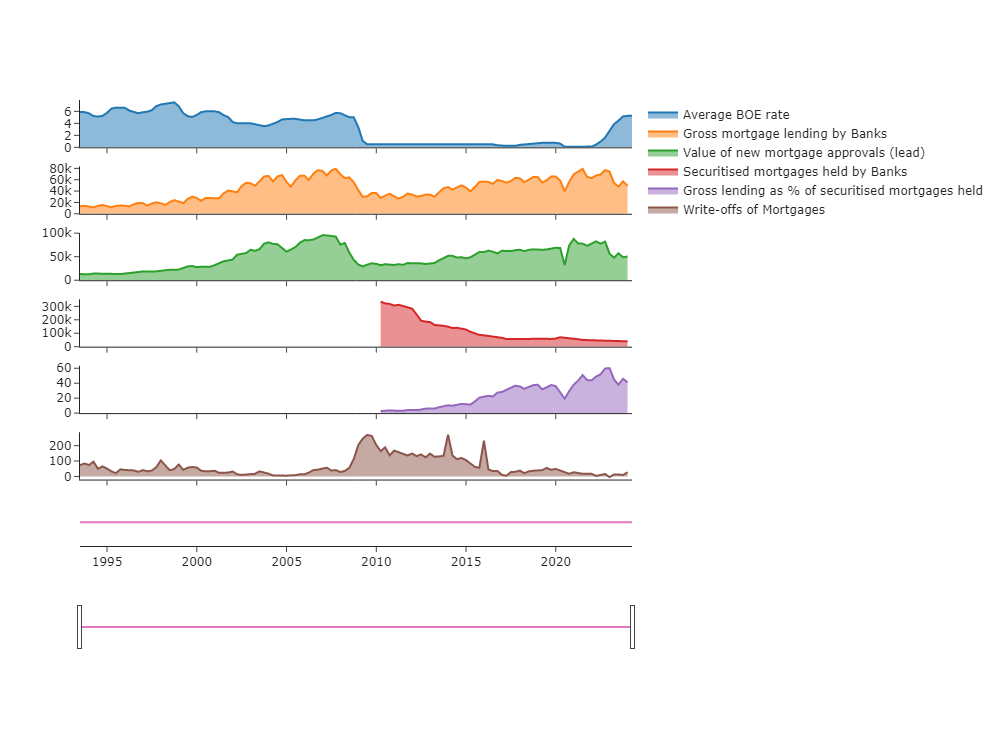

In [3]:
fig = make_subplots(rows=7, cols=1, shared_xaxes=True)

fig.add_trace(go.Scatter(x=df2['DATE'], y=df2['IUQABEDR'], mode='lines', name='Average BOE rate', fill='tozeroy'), row=1, col=1)
fig.add_trace(go.Scatter(x=df2['DATE'], y=df2['LPQB3VB'], mode='lines', name='Gross mortgage lending by Banks', fill='tozeroy'), row=2, col=1)
fig.add_trace(go.Scatter(x=df2['DATE'], y=df2['LPQVTVQ'], mode='lines', name='Value of new mortgage approvals (lead)', fill='tozeroy'), row=3, col=1)
fig.add_trace(go.Scatter(x=df2['DATE'], y=df2['LPMB7GT'], mode='lines', name='Securitised mortgages held by Banks',fill='tozeroy'), row=4, col=1)
fig.add_trace(go.Scatter(x=df2['DATE'], y=df2['Sec_Pct'], mode='lines', name='Gross lending as % of securitised mortgages held', fill='tozeroy'), row=5, col=1)
fig.add_trace(go.Scatter(x=df2['DATE'], y=df2['RPQTFHD'], mode='lines', name='Write-offs of Mortgages', fill='tozeroy'), row=6, col=1)
fig.add_trace(go.Scatter(x=df2['DATE'], y=[0 for _ in df2['DATE']], mode='lines', showlegend=False), row=7, col=1)

fig.update_yaxes(visible=False, showticklabels=False,showgrid=False, zeroline=False, row=7)
fig.update_xaxes(showgrid=False, zeroline=False,rangeslider_visible=True, row=7, col=1)
fig.update_layout(height=750, width=1000, template="simple_white")  # Adjust height and width as needed
fig.show() # render in google collab, use just fig.show() if local machine

<a name="Anchor_Section3"></a>
## **Section 3: BOE Bank Rate range & density of mortgage lending and holdings of structured securities**
Explore how historic density distribution of gross lending and securitisation activity changes across different monetary policy regimes.
##**How to use:**
1.   Execute the code cell below after [importing packages](#Anchor_Section1) and [reading the API data](#Anchor_Section2).
2.   Adjust the range slider and select series to explore. Wait for plotly display device to update with widget input.



In [ ]:
default_column = 'LPQB3VB'
data = df2[default_column]

# Handle NaNs for Histogram and KDE
clean_data = data.replace([np.inf, -np.inf], np.nan).dropna()
kde = gaussian_kde(clean_data)
y_kde = np.linspace(clean_data.min(), clean_data.max(), 50)
x_kde = kde(y_kde)

# Create plots
scatter = go.Scatter(x=df2['DATE'], y=data, mode='markers', name='Scatter')
histogram = go.Histogram(y=clean_data, orientation='h', nbinsy=10, name='Histogram', histnorm='probability density')
kde_trace = go.Scatter(y=y_kde, x=x_kde, mode='lines', name='KDE',line=dict(color='black'))

# Combine into a single interactive figure
fig_combined = go.FigureWidget(make_subplots(rows=1, cols=2, subplot_titles=('Scatter', 'Histogram & KDE')))
fig_combined.update_layout(height=500, width=1000,template="simple_white")
fig_combined.add_trace(scatter, row=1, col=1)
fig_combined.add_trace(histogram, row=1, col=2)
fig_combined.add_trace(kde_trace, row=1, col=2)

# Update scatter plot and histogram in fig_combined based on slider and dropdown values
def update_plot(column, range_vals):
    mask = (df2['IUQABEDR'] >= range_vals[0]) & (df2['IUQABEDR'] <= range_vals[1])
    filtered_data = df2[mask]
    selected_data = filtered_data[column]
    clean_selected_data = selected_data.replace([np.inf, -np.inf], np.nan).dropna()
    # Update plots
    fig_combined.data[0].x = filtered_data['DATE'].tolist()
    fig_combined.data[0].y = selected_data.tolist()
    fig_combined.data[1].y = clean_selected_data.tolist()
    # Update KDE
    kde = gaussian_kde(clean_selected_data)
    y_kde = np.linspace(clean_selected_data.min(), clean_selected_data.max(), 50)
    x_kde = kde(y_kde)
    fig_combined.data[2].y = y_kde
    fig_combined.data[2].x = x_kde
    # Update plot render in google collab \\ remove completely if running on local machine
# Dropdown for column selection
dropdown = Dropdown(
    options=df2.columns[(df2.dtypes != 'datetime64[ns]') & (df2.dtypes != 'object')].tolist(),
    value=default_column,
    description='Series:')

# Float range slider for bank rate
min_val2, max_val2 = df2['IUQABEDR'].min(), df2['IUQABEDR'].max()
slider = FloatRangeSlider(
    value=[min_val2, max_val2],
    min=min_val2,
    max=max_val2,
    step=0.01,
    description='BOE Rate:',
    continuous_update=True)

interact(update_plot, column=dropdown, range_vals=slider)
fig_combined

<img src="Mortgage_Tutorial.gif" alt="Alt text" width="1200"/>